In [1]:
import os, torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt, numpy as np, cv2, time
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
classes = ['screw','metal_nut','cable']
transform = transforms.Compose([
transforms.Resize((256,256)),
transforms.ToTensor()
])

def load_datasets():
    sets = []
    for cls in classes:
        ds = datasets.ImageFolder(root=f'data/mvtec_ad/{cls}/train', transform=transform)
        sets.append(ds)
    return ConcatDataset(sets)

train_data = load_datasets()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

In [3]:
class BaseCAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
        nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), nn.ReLU(),
        nn.ConvTranspose2d(32, 3, 3, 2, 1, 1), nn.Sigmoid()
        )
    def forward(self,x): 
        return self.decoder(self.encoder(x))

In [4]:
class DeepCAE(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, 3, 2, 1), nn.LeakyReLU(0.1),
        nn.Conv2d(32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.1),
        nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.1),
        nn.Conv2d(128, 256, 3, 2, 1), nn.LeakyReLU(0.1),
        nn.Dropout(dropout)
        )
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 3, 2, 1, 1), nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), nn.ReLU(),
        nn.ConvTranspose2d(32, 3, 3, 2, 1, 1), nn.Sigmoid()
        )
    def forward(self,x): 
        return self.decoder(self.encoder(x))

In [5]:
class DenoisingCAE(nn.Module):
    def __init__(self, noise_std=0.05):
        super().__init__()
        self.noise_std = noise_std
        self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
        nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), nn.ReLU(),
        nn.ConvTranspose2d(32, 3, 3, 2, 1, 1), nn.Sigmoid()
        )
    def forward(self,x):
        noise = torch.randn_like(x) * self.noise_std
        return self.decoder(self.encoder(x + noise))

In [6]:
import itertools, pandas as pd

def train_model(model, optimizer_name, lr=1e-3, epochs=20, batch_size=32):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    opt_dict = {
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "RMSProp": optim.RMSprop(model.parameters(), lr=lr),
        "SGD": optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    }
    optimizer = opt_dict[optimizer_name]
    loss_fn = nn.MSELoss()
    best_loss = float('inf')

    for ep in range(epochs):
        total = 0
        model.train()
        for x, _ in train_loader:
            x = x.to(device)
            recon = model(x)
            loss = loss_fn(recon, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += loss.item()
        avg = total / len(train_loader)
        print(f"{type(model).__name__} | {optimizer_name} | Ep {ep+1}/{epochs} | Loss {avg:.5f}")
        if avg < best_loss:
            best_loss = avg
            torch.save(model.state_dict(), f"results/{type(model).__name__}_{optimizer_name}_best.pth")
    return best_loss

os.makedirs("results", exist_ok=True)

learning_rates = [0.001, 0.0001]
batch_sizes = [32] 
epochs_list = [10, 20]
optimizers = ["Adam", "RMSProp"]
dropouts = [0.3, 0.5]

model_configs = {
    "BaseCAE": BaseCAE,
    "DeepCAE": DeepCAE,
    "DenoisingCAE": DenoisingCAE
}

results = []

for model_name, model_class in model_configs.items():
    print(f"\n===== Tuning {model_name} =====")
    for lr, drop, opt_name, ep, bs in itertools.product(learning_rates, dropouts, optimizers, epochs_list, batch_sizes):
        if model_name == "DeepCAE":
            model = model_class(dropout=drop)
        elif model_name == "DenoisingCAE":
            model = model_class(noise_std=0.05)
        else:
            model = model_class()
        start = time.time()
        best_loss = train_model(model, optimizer_name=opt_name, lr=lr, epochs=ep, batch_size=bs)
        elapsed = round(time.time() - start, 1)
        results.append({
            "Model": model_name, "LR": lr, "Dropout": drop,
            "Optimizer": opt_name, "Batch": bs, "Epochs": ep,
            "Best_Loss": best_loss, "Time_sec": elapsed
        })

df = pd.DataFrame(results)
display(df.sort_values("Best_Loss"))
best_cfg = df.loc[df["Best_Loss"].idxmin()]
print(f"\n Best Configuration:\n{best_cfg}")



===== Tuning BaseCAE =====
BaseCAE | Adam | Ep 1/10 | Loss 0.05166
BaseCAE | Adam | Ep 2/10 | Loss 0.01191
BaseCAE | Adam | Ep 3/10 | Loss 0.00580
BaseCAE | Adam | Ep 4/10 | Loss 0.00464
BaseCAE | Adam | Ep 5/10 | Loss 0.00409
BaseCAE | Adam | Ep 6/10 | Loss 0.00387
BaseCAE | Adam | Ep 7/10 | Loss 0.00364
BaseCAE | Adam | Ep 8/10 | Loss 0.00319
BaseCAE | Adam | Ep 9/10 | Loss 0.00278
BaseCAE | Adam | Ep 10/10 | Loss 0.00238
BaseCAE | Adam | Ep 1/20 | Loss 0.05362
BaseCAE | Adam | Ep 2/20 | Loss 0.01325
BaseCAE | Adam | Ep 3/20 | Loss 0.00639
BaseCAE | Adam | Ep 4/20 | Loss 0.00490
BaseCAE | Adam | Ep 5/20 | Loss 0.00411
BaseCAE | Adam | Ep 6/20 | Loss 0.00354
BaseCAE | Adam | Ep 7/20 | Loss 0.00359
BaseCAE | Adam | Ep 8/20 | Loss 0.00353
BaseCAE | Adam | Ep 9/20 | Loss 0.00312
BaseCAE | Adam | Ep 10/20 | Loss 0.00303
BaseCAE | Adam | Ep 11/20 | Loss 0.00296
BaseCAE | Adam | Ep 12/20 | Loss 0.00278
BaseCAE | Adam | Ep 13/20 | Loss 0.00267
BaseCAE | Adam | Ep 14/20 | Loss 0.00252
BaseCA

,Model,LR,Dropout,Optimizer,Batch,Epochs,Best_Loss,Time_sec
33,DenoisingCAE,0.0010,0.3,Adam,32,20,0.001362,1116.5
5,BaseCAE,0.0010,0.5,Adam,32,20,0.001396,1398.7
37,DenoisingCAE,0.0010,0.5,Adam,32,20,0.001473,1108.2
1,BaseCAE,0.0010,0.3,Adam,32,20,0.001484,21095.9
7,BaseCAE,0.0010,0.5,RMSProp,32,20,0.002256,1103.2
35,DenoisingCAE,0.0010,0.3,RMSProp,32,20,0.002256,1137.9
36,DenoisingCAE,0.0010,0.5,Adam,32,10,0.002303,557.9
0,BaseCAE,0.0010,0.3,Adam,32,10,0.002377,1575.7
3,BaseCAE,0.0010,0.3,RMSProp,32,20,0.002693,8660.9
32,DenoisingCAE,0.0010,0.3,Adam,32,10,0.002743,561.1



 Best Configuration:
Model        DenoisingCAE
LR                  0.001
Dropout               0.3
Optimizer            Adam
Batch                  32
Epochs                 20
Best_Loss        0.001362
Time_sec           1116.5
Name: 33, dtype: object


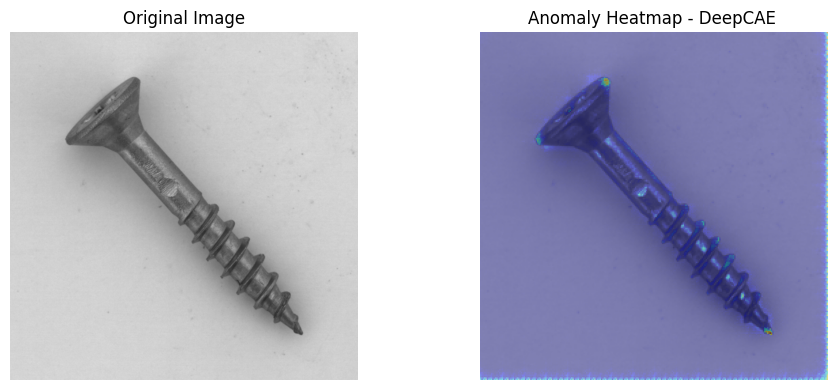

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def visualize(model, img_path, title_extra=""):
    # Load and preprocess
    img = Image.open(img_path).convert('RGB')
    x = transform_eval(img).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        recon = model(x)

    # Compute reconstruction error map
    err = torch.mean((x - recon)**2, dim=1).squeeze().cpu().numpy()
    err = (err - err.min()) / (err.max() - err.min() + 1e-8)

    # Generate heatmap overlay
    heat = cv2.applyColorMap(np.uint8(255 * err), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(img.resize((256,256)))[:,:,::-1], 0.6, heat, 0.4, 0)

    # --- Visualization: Original + Heatmap ---
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Anomaly Heatmap - {type(model).__name__} {title_extra}")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage
model = DeepCAE()
model.load_state_dict(torch.load('results/DeepCAE_Adam_best.pth', map_location=device))
model.eval()

visualize(model, 'data/mvtec_ad/screw/test/scratch_neck/010.png')


Detected columns: Index(['model', 'lr', 'dropout', 'optimizer', 'batch', 'epochs', 'best_loss',
       'time_s'],
      dtype='object')


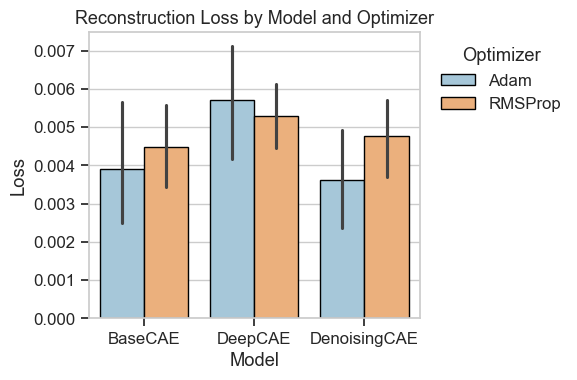

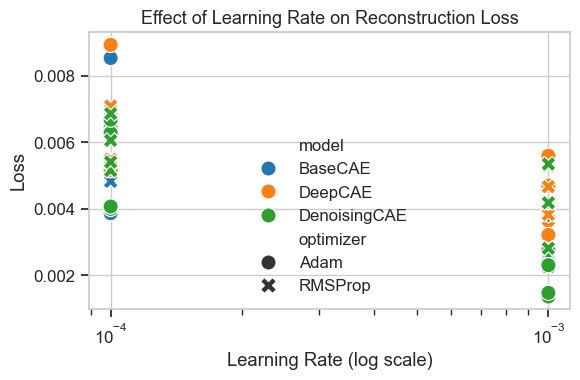

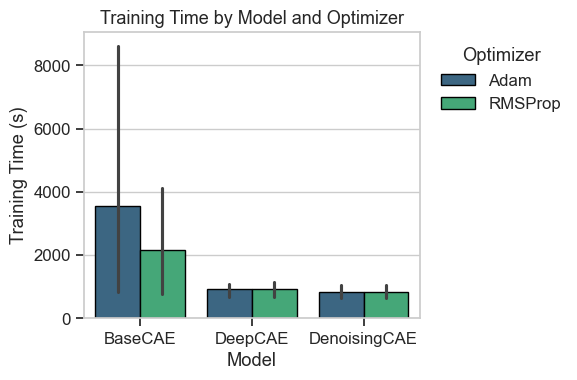

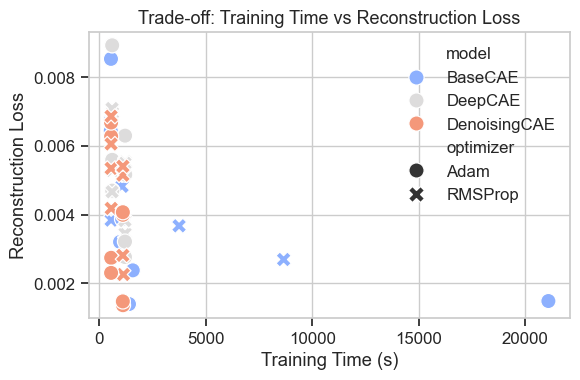


Best Configuration:



,model,lr,dropout,optimizer,batch,epochs,best_loss,time_s
33,DenoisingCAE,0.001,0.3,Adam,32,20,0.001362,1116.5


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---- Normalize & detect columns ----
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("Detected columns:", df.columns)
col_map = {
    'model': next((c for c in df.columns if 'model' in c), None),
    'lr': next((c for c in df.columns if 'lr' in c or 'learning' in c), None),
    'optimizer': next((c for c in df.columns if 'opt' in c), None),
    'loss': next((c for c in df.columns if 'loss' in c), None),
    'time': next((c for c in df.columns if 'time' in c or 'sec' in c), None)
}

# print("Column mapping:", col_map)
# for key, val in col_map.items():
#     if val is None:
#         raise KeyError(f"❌ Column for '{key}' not found in DataFrame. Found: {list(df.columns)}")

# ---- Plotting ----
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Reconstruction Loss by Model & Optimizer
plt.figure(figsize=(6,4))
sns.barplot(data=df, x=col_map['model'], y=col_map['loss'], hue=col_map['optimizer'],
            palette=["#9ecae1","#fdae6b"], edgecolor="black")
plt.title("Reconstruction Loss by Model and Optimizer", fontsize=13)
plt.xlabel("Model"); plt.ylabel("Loss")
plt.legend(title="Optimizer", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Learning Rate vs Loss (log scale)
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x=col_map['lr'], y=col_map['loss'],
                hue=col_map['model'], style=col_map['optimizer'], s=120, palette="tab10")
plt.xscale("log")
plt.title("Effect of Learning Rate on Reconstruction Loss", fontsize=13)
plt.xlabel("Learning Rate (log scale)"); plt.ylabel("Loss")
plt.tight_layout()
plt.show()

# Training Time by Model
plt.figure(figsize=(6,4))
sns.barplot(data=df, x=col_map['model'], y=col_map['time'], hue=col_map['optimizer'],
            palette="viridis", edgecolor="black")
plt.title("Training Time by Model and Optimizer", fontsize=13)
plt.xlabel("Model"); plt.ylabel("Training Time (s)")
plt.legend(title="Optimizer", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Trade-off: Training Time vs Loss
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x=col_map['time'], y=col_map['loss'],
                hue=col_map['model'], style=col_map['optimizer'], s=120, palette="coolwarm")
plt.title("Trade-off: Training Time vs Reconstruction Loss", fontsize=13)
plt.xlabel("Training Time (s)"); plt.ylabel("Reconstruction Loss")
plt.tight_layout()
plt.show()

# Display best configuration row
best_idx = df[col_map['loss']].idxmin()
print("\nBest Configuration:\n")
display(df.loc[[best_idx]])
